## Cellpose-SAM: superhuman generalization for cellular segmentation

Marius Pachitariu, Michael Rariden, Carsen Stringer

[paper](https://www.biorxiv.org/content/10.1101/2025.04.28.651001v1) | [code](https://github.com/MouseLand/cellpose)

This notebook shows how to process your own 2D or 3D images, saved on Google Drive.

This notebook is adapted from the notebook by Pradeep Rajasekhar, inspired by the [ZeroCostDL4Mic notebook series](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki).

In [1]:
from cellpose import models
from cellpose.io import imread
from pathlib import Path

path = r"D:\tests\data\assembled\roi2"
imgs = [x for x in Path(path).glob("*.tif*")]



Welcome to CellposeSAM, cellpose v
cellpose version: 	0.1.dev1380+g79b0fcb 
platform:       	win32 
python version: 	3.13.3 
torch version:  	2.7.1+cu126! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




In [2]:
from re import search
imgs= sorted(imgs, key=lambda p: int(search(r"\d+", p.stem).group()))
imgs

[WindowsPath('D:/tests/data/assembled/roi2/plane1.tif'),
 WindowsPath('D:/tests/data/assembled/roi2/plane2.tif'),
 WindowsPath('D:/tests/data/assembled/roi2/plane3.tif'),
 WindowsPath('D:/tests/data/assembled/roi2/plane4.tif'),
 WindowsPath('D:/tests/data/assembled/roi2/plane5.tif'),
 WindowsPath('D:/tests/data/assembled/roi2/plane6.tif'),
 WindowsPath('D:/tests/data/assembled/roi2/plane7.tif'),
 WindowsPath('D:/tests/data/assembled/roi2/plane8.tif'),
 WindowsPath('D:/tests/data/assembled/roi2/plane9.tif'),
 WindowsPath('D:/tests/data/assembled/roi2/plane10.tif'),
 WindowsPath('D:/tests/data/assembled/roi2/plane11.tif'),
 WindowsPath('D:/tests/data/assembled/roi2/plane12.tif'),
 WindowsPath('D:/tests/data/assembled/roi2/plane13.tif'),
 WindowsPath('D:/tests/data/assembled/roi2/plane14.tif')]

In [3]:
import numpy as np
import tifffile
img = np.stack([tifffile.memmap(path).mean(axis=0) for path in imgs])
img = img[np.newaxis, :, :, :]

In [4]:
img.shape

(1, 14, 448, 224)

## mk301: Roi-2 Z-Stack with defaults

In [5]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Sep_12_02:55:00_Pacific_Daylight_Time_2024
Cuda compilation tools, release 12.6, V12.6.77
Build cuda_12.6.r12.6/compiler.34841621_0


Note `build cuda_12.6`

In [6]:
!uv pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

Using Python 3.13.3 environment at: C:\Users\RBO\repos\cellpose\.venv
Audited 3 packages in 9ms


Save and refresh your browser

In [8]:
first_channel = '0' # @param ['None', 0, 1, 2, 3, 4, 5]
second_channel = '1' # @param ['None', 0, 1, 2, 3, 4, 5]
third_channel = '2' # @param ['None', 0, 1, 2, 3, 4, 5]

In [9]:
selected_channels = []
for i, c in enumerate([first_channel, second_channel, third_channel]):
  if c == 'None':
    continue
  if int(c) > img.shape[-1]:
    assert False, 'invalid channel index, must have index greater or equal to the number of channels'
  if c != 'None':
    selected_channels.append(int(c))

img_selected_channels = np.zeros_like(img)
img_selected_channels[:, :, :len(selected_channels)] = img[:, :, selected_channels]

In [10]:
model = models.CellposeModel(gpu=True)

res = model.eval(
    img,
    do_3D=True,
    flow_threshold=0.4,
    cellprob_threshold=0,
    channel_axis=0,
    z_axis=1,
)

In [11]:
masks, flows, styles = res

In [42]:
np.save("./styles", styles)

In [13]:
import numpy as np
from cellpose import plot

In [13]:
flows = np.load("./flows.npy")
masks = np.load("./masks.npy")
styles = np.load("./styles.npy")

In [16]:
img.shape

(1, 14, 448, 224)

In [17]:
masks.shape

(14, 448, 224)

In [19]:
len(flows)

3

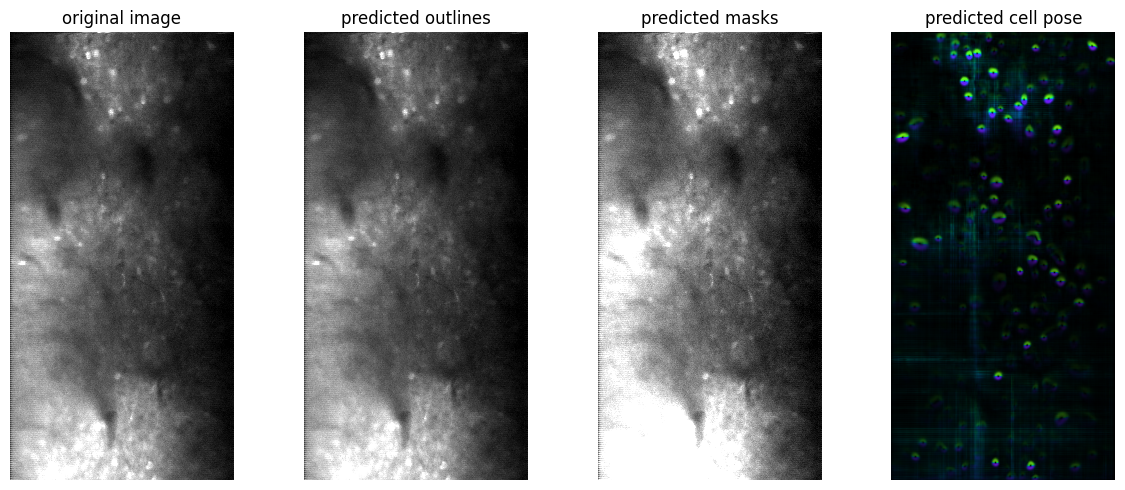

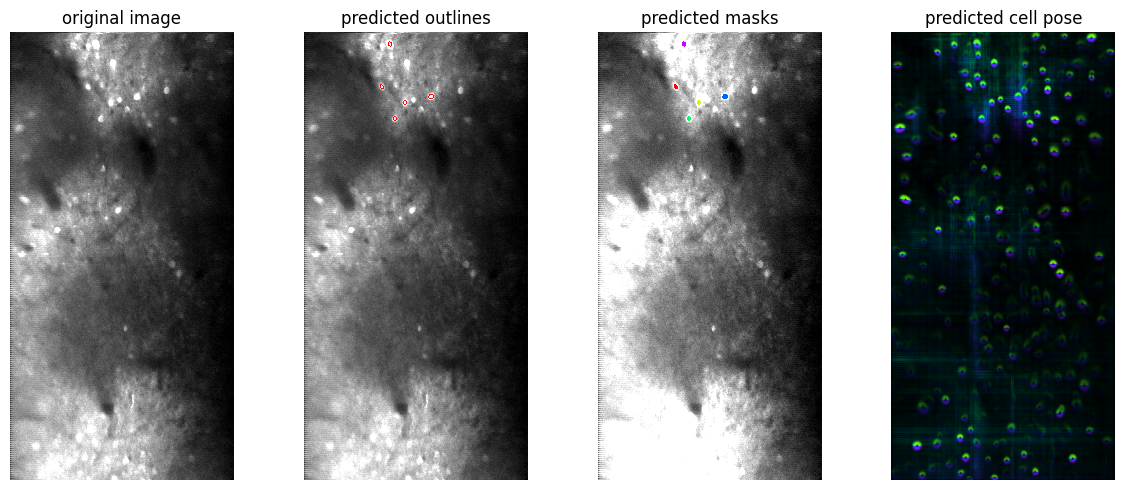

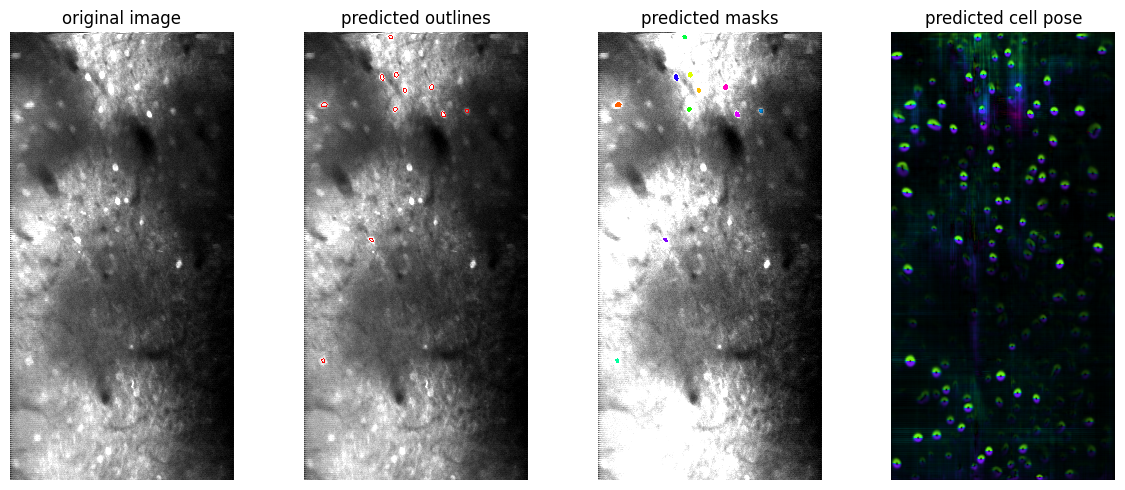

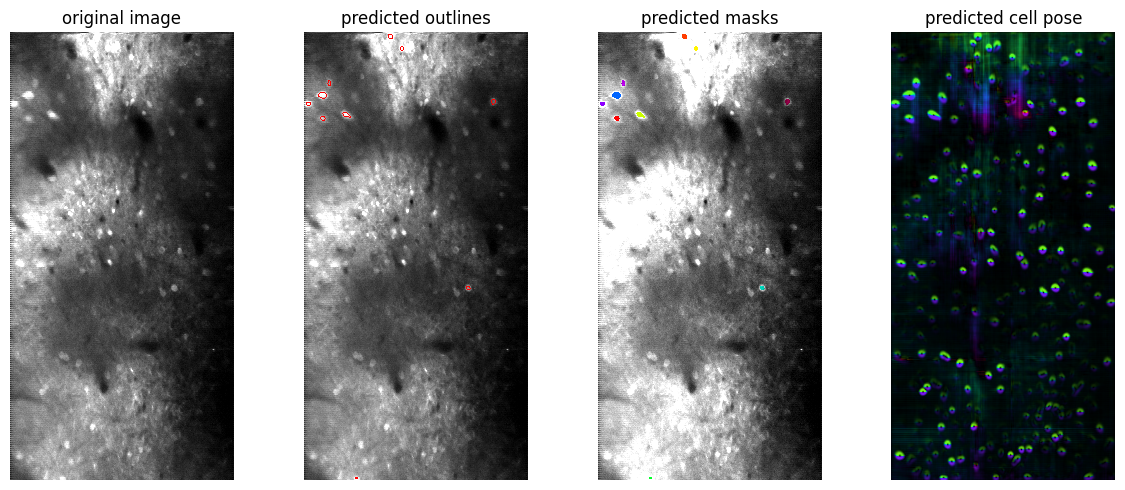

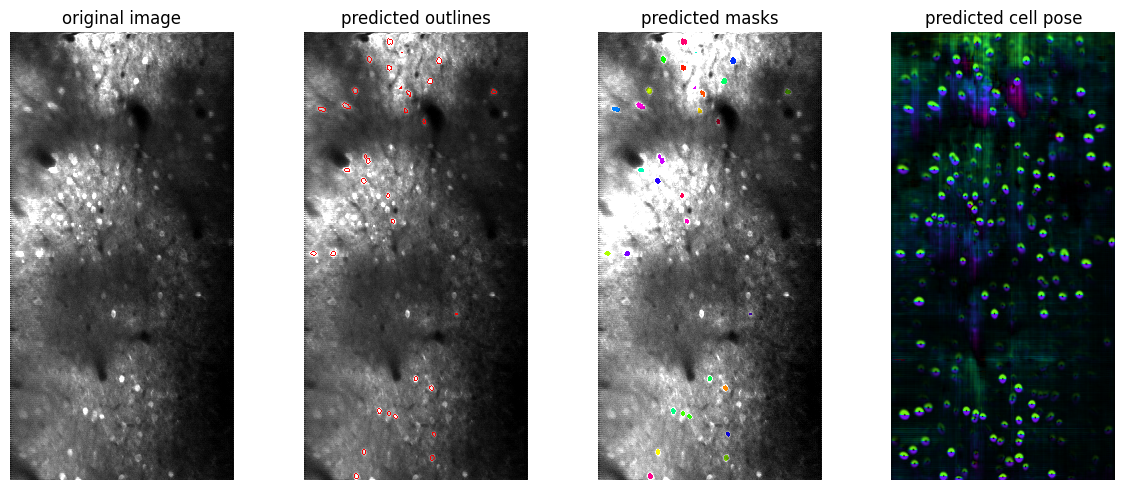

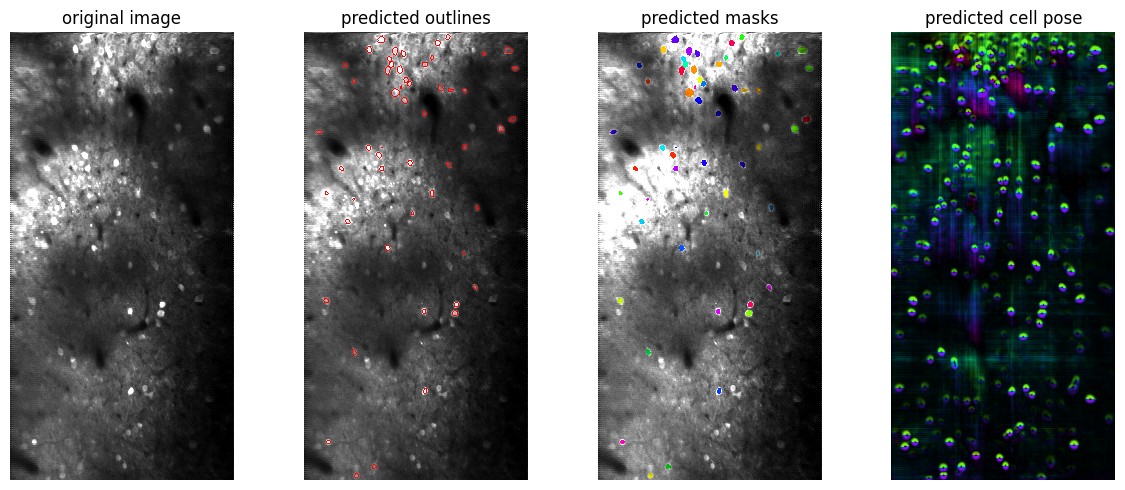

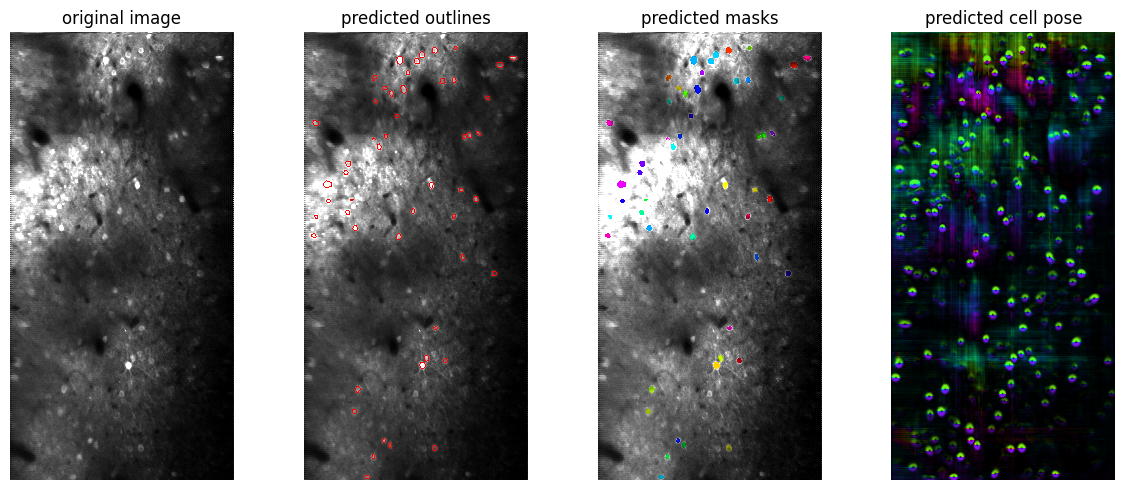

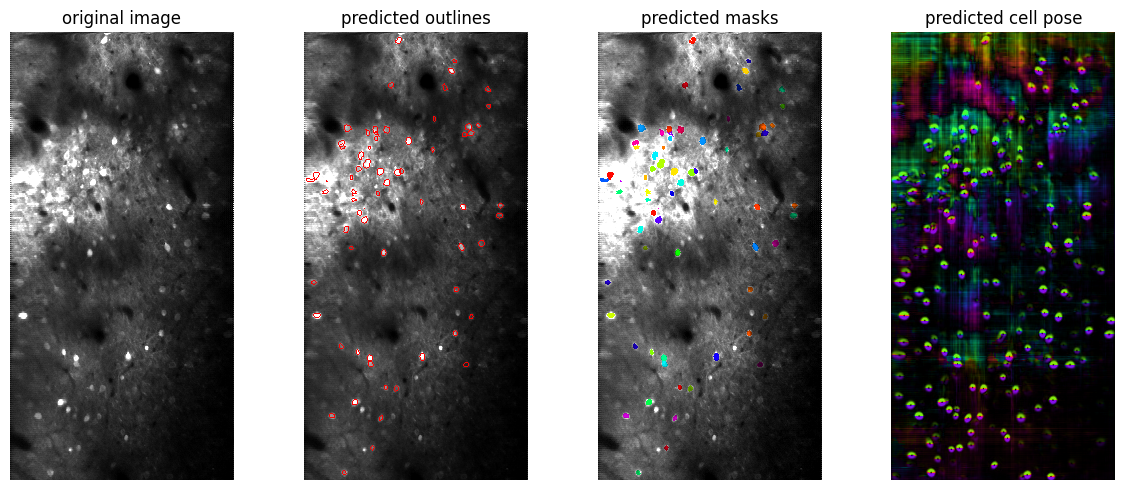

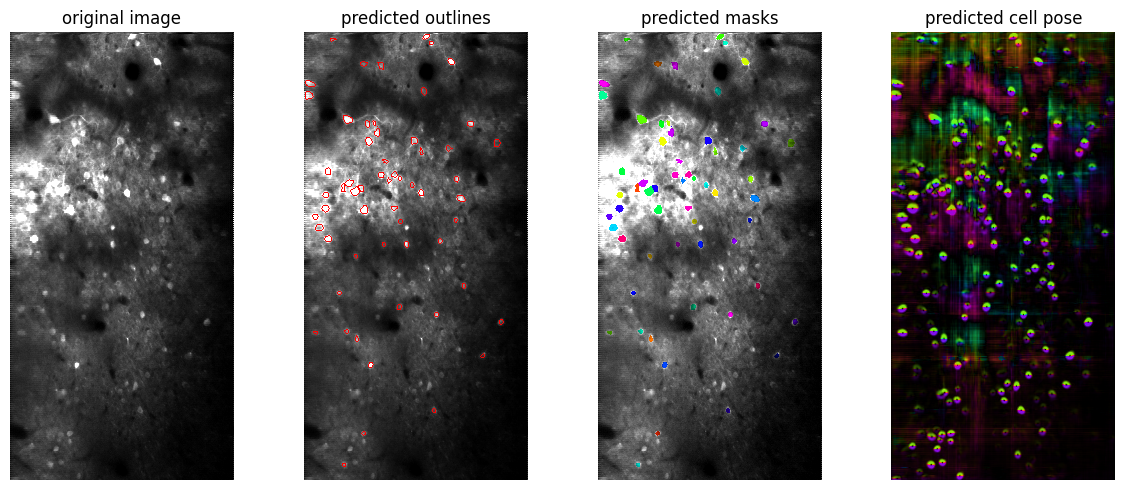

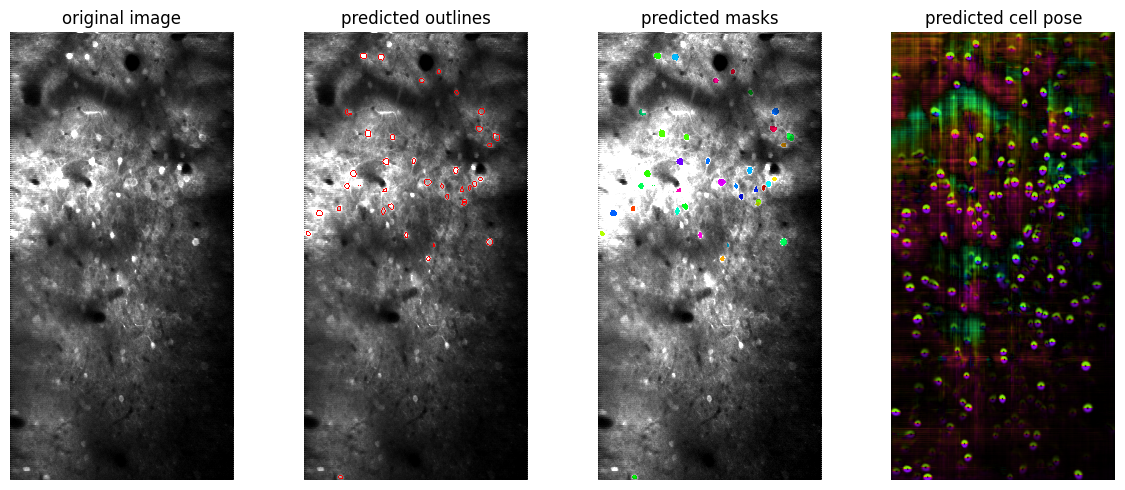

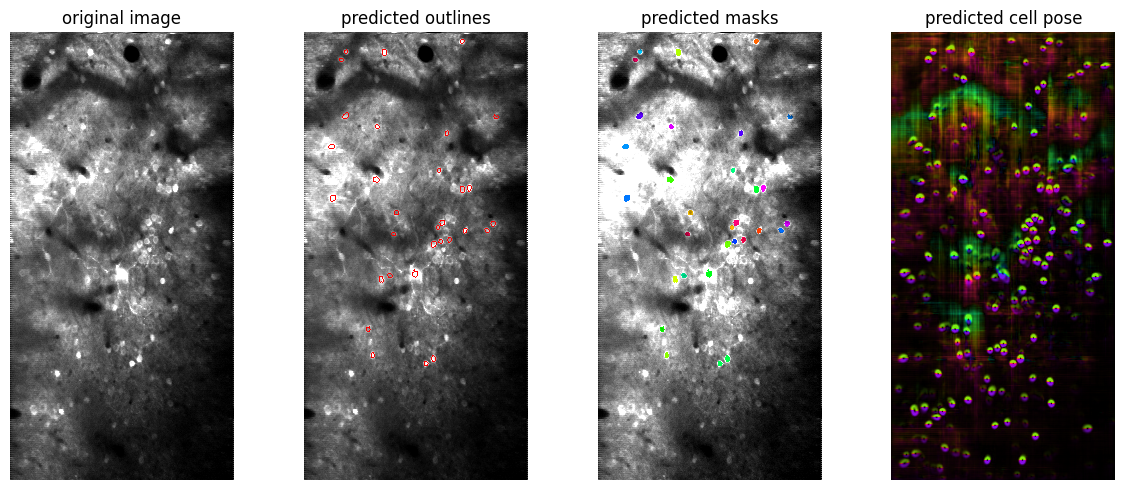

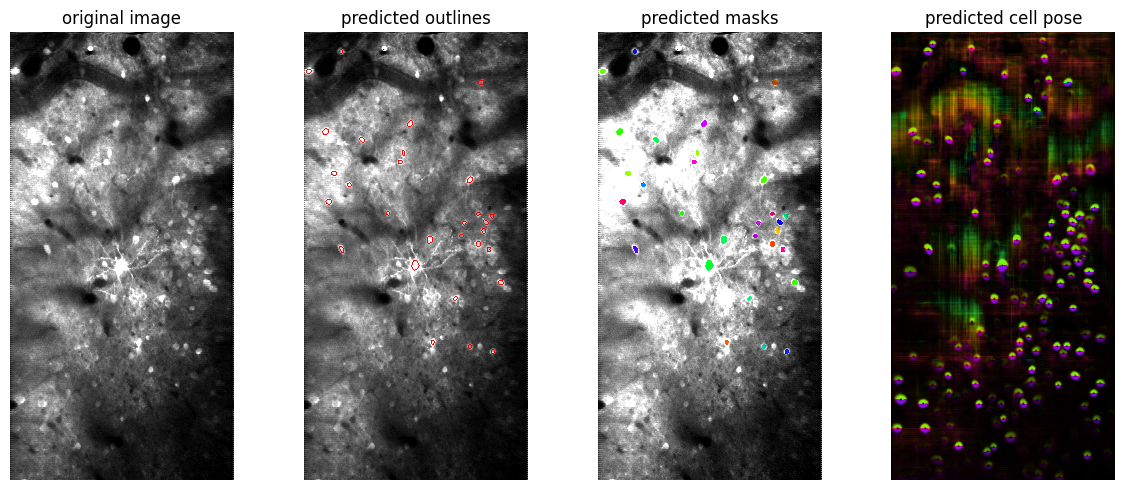

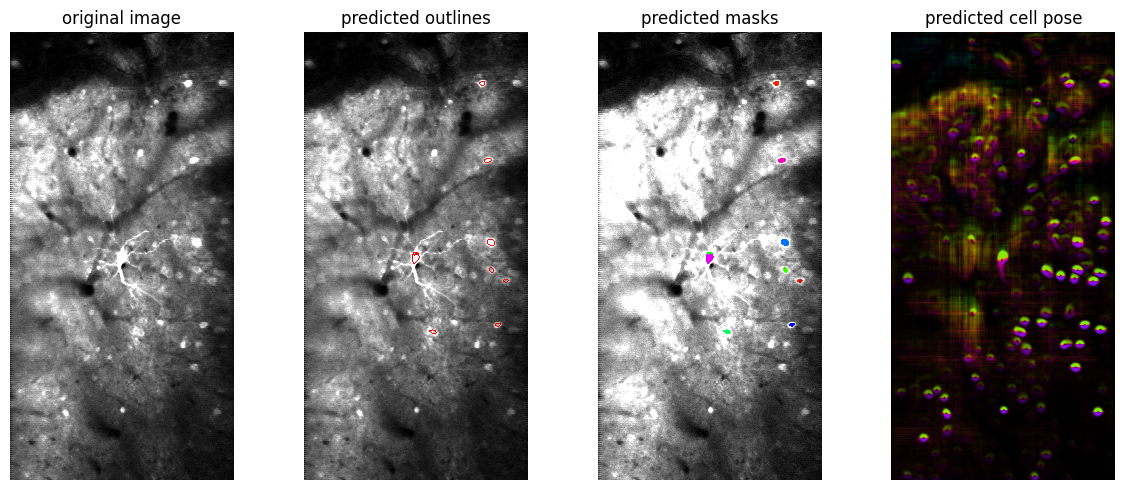

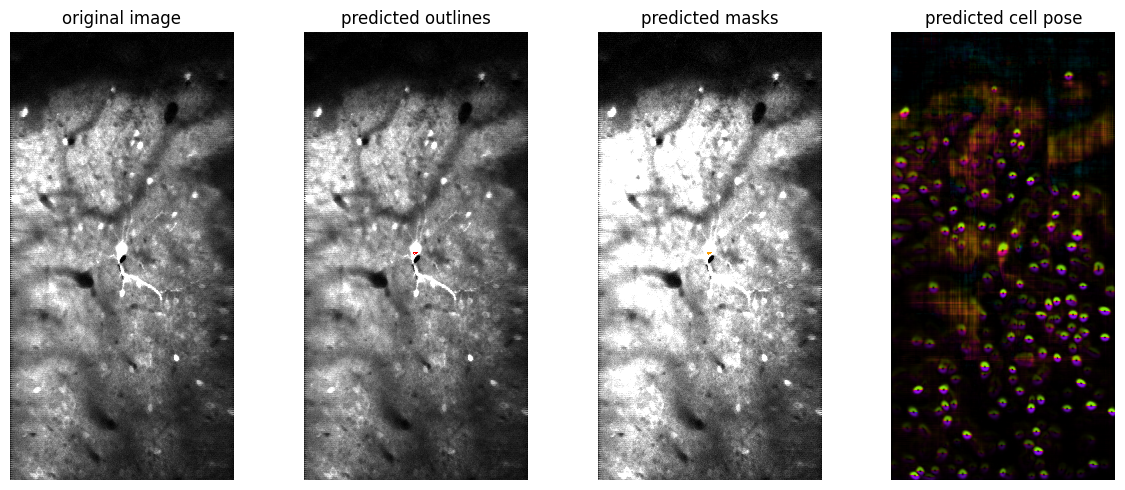

In [22]:
for z in range(img.shape[1]):
    fig = plt.figure(figsize=(12, 5))
    plot.show_segmentation(fig, img[0, z], masks[z], flows[0][z], channels=[0, 0])
    plt.tight_layout()
    plt.show()


### Install Cellpose-SAM

In [ ]:
!pip install git+https://www.github.com/mouseland/cellpose.git

Check GPU and instantiate model - will download weights.

In [ ]:
import numpy as np
from cellpose import models, core, io, plot
from pathlib import Path
from tqdm import trange
import matplotlib.pyplot as plt
from natsort import natsorted

io.logger_setup() # run this to get printing of progress

#Check if colab notebook instance has GPU access
if core.use_gpu()==False:
  raise ImportError("No GPU access, change your runtime")

model = models.CellposeModel(gpu=True)

Input directory with your images:

In [ ]:
# *** change to your google drive folder path ***
dir = "/content/gdrive/MyDrive/PATH-TO-FILES/"
dir = Path(dir)
if not dir.exists():
  raise FileNotFoundError("directory does not exist")

# *** change to your image extension ***
image_ext = ".tif"

# list all files
files = natsorted([f for f in dir.glob("*"+image_ext) if "_masks" not in f.name and "_flows" not in f.name])

if(len(files)==0):
  raise FileNotFoundError("no image files found, did you specify the correct folder and extension?")
else:
  print(f"{len(files)} images in folder:")

for f in files:
  print(f.name)

## Run Cellpose-SAM on one image in folder

Here are some of the parameters you can change:

* ***flow_threshold*** is  the  maximum  allowed  error  of  the  flows  for  each  mask.   The  default  is 0.4.
    *  **Increase** this threshold if cellpose is not returning as many masks as you’d expect (or turn off completely with 0.0)
    *   **Decrease** this threshold if cellpose is returning too many ill-shaped masks.

* ***cellprob_threshold*** determines proability that a detected object is a cell.   The  default  is 0.0.
    *   **Decrease** this threshold if cellpose is not returning as many masks as you’d expect or if masks are too small
    *   **Increase** this threshold if cellpose is returning too many masks esp from dull/dim areas.

* ***tile_norm_blocksize*** determines the size of blocks used for normalizing the image. The default is 0, which means the entire image is normalized together.
  You may want to change this to 100-200 pixels if you have very inhomogeneous brightness across your image.



In [ ]:
img = io.imread(files[0])

print(f'your image has shape: {img.shape}. Assuming channel dimension is last with {img.shape[-1]} channels')

### Channel Selection: 

- Use the dropdowns below to select the _zero-indexed_ channels of your image to segment. The order does not matter. Remember to rerun the cell after you edit the dropdowns.

- If you have a histological image taken in brightfield, you don't need to adjust the channels.

- If you have a fluroescent image with multiple stains, you should choose one channel with a cytoplasm/membrane stain, one channel with a nuclear stain, and set the third channel to `None`. Choosing multiple channels may produce segmentaiton of all the structures in the image. If you have retrained the model on your data with a thrid stain (described below), you can run segmentation with all channels. 

In [ ]:
first_channel = '0' # @param ['None', 0, 1, 2, 3, 4, 5]
second_channel = '1' # @param ['None', 0, 1, 2, 3, 4, 5]
third_channel = '2' # @param ['None', 0, 1, 2, 3, 4, 5]

In [ ]:
selected_channels = []
for i, c in enumerate([first_channel, second_channel, third_channel]):
  if c == 'None':
    continue
  if int(c) > img.shape[-1]:
    assert False, 'invalid channel index, must have index greater or equal to the number of channels'
  if c != 'None':
    selected_channels.append(int(c))



img_selected_channels = np.zeros_like(img)
img_selected_channels[:, :, :len(selected_channels)] = img[:, :, selected_channels]


flow_threshold = 0.4
cellprob_threshold = 0.0
tile_norm_blocksize = 0

masks, flows, styles = model.eval(img_selected_channels, batch_size=32, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold,
                                  normalize={"tile_norm_blocksize": tile_norm_blocksize})

fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img_selected_channels, masks, flows[0])
plt.tight_layout()
plt.show()


## Run Cellpose-SAM on folder of images

if you have many large images, you may want to run them as a loop over images



In [ ]:
masks_ext = ".png" if image_ext == ".png" else ".tif"
for i in trange(len(files)):
    f = files[i]
    img = io.imread(f)
    masks, flows, styles = model.eval(img, batch_size=32, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold,
                                  normalize={"tile_norm_blocksize": tile_norm_blocksize})
    io.imsave(dir / (f.stem + "_masks" + masks_ext), masks)

if you have small images, you may want to load all of them first and then run, so that they can be batched together on the GPU

In [ ]:
print("loading images")
imgs = [io.imread(files[i]) for i in trange(len(files))]

print("running cellpose-SAM")
masks, flows, styles = model.eval(imgs, batch_size=32, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold,
                                  normalize={"tile_norm_blocksize": tile_norm_blocksize})

print("saving masks")
for i in trange(len(files)):
    f = files[i]
    io.imsave(dir / (f.stem + "_masks" + masks_ext), masks[i])

to save your masks for ImageJ, run the following code:

In [ ]:
for i in trange(len(files)):
    f = files[i]
    masks0 = io.imsave(dir / (f.name + "_masks" + masks_ext))
    io.save_rois(masks0, f)